In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import expm1
from sasmodels.special import sas_2J1x_x, sas_sinx_x, sas_Si
from scipy.special import j0 as sas_J0x 
import pdb

## Parameters for testing from the paper

In [11]:
# compute for homogenous contrast
rho_solv = 1
rho_s = rho_solv+1
rho_c = rho_solv+1

# Example (units in Å)
Vc = 4000
Vs = 4000
R = 40
L = [200, 400, 1000, 10000]
N = 67
Rg = 10
d = 1.0
V_total = N*(Vs+Vc) 

## Final kernel

In [12]:
def micelle_longcylinder_kernel(q,
        v_core=None,
        v_corona=None,
        v_total=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        length_core=None,
        d_penetration=None,
        n_aggreg=None):
    
    v_total = n_aggreg*(v_core+v_corona)
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)

    # Self-correlation term of the core
    ff_crossec = sas_2J1x_x(q*radius_core)
    ff_thinrod_term1 = sas_Si(q*length_core)/(q*length_core)
    ff_thinrod_term2 = sas_sinx_x((q*length_core)/2)
    ff_thinrod = 2*ff_thinrod_term1 - np.power(ff_thinrod_term2, 2)

    Fs = np.power(ff_crossec, 2)*ff_thinrod
    term1 = np.power(n_aggreg*beta_core, 2)*Fs 

    # Self-correlation term of the chains
    qrg2 = np.power(q*rg, 2)
    debye_chain = 2.0*(np.vectorize(expm1)(-qrg2)+qrg2)/(qrg2**2) 
    debye_chain[qrg2==0.0] = 1.0
    term2 = n_aggreg * (beta_corona**2) * debye_chain

    # Interference cross-term between core and chains
    qrg = q*rg
    chain_ampl = -np.vectorize(expm1)(-qrg)/qrg
    chain_ampl[qrg==0.0] =  1.0 
    ff_chain = sas_J0x(q*(radius_core+ d_penetration*rg))
    Ssc = chain_ampl*ff_crossec*ff_chain*ff_thinrod
    term3 = 2.0 * (n_aggreg**2) * beta_core * beta_corona * Ssc

    # Interference cross-term between chains
    Scc = (chain_ampl**2) * (np.power(ff_chain,2)) * ff_thinrod
    term4 = n_aggreg * (n_aggreg - 1.0)* (beta_corona**2)*Scc

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4 
    # print('Different terms : ', term1, term2, term3, term4)

    # Normalize intensity by total volume
    return i_micelle/v_total

## Example to compare with the paper qualitatively 

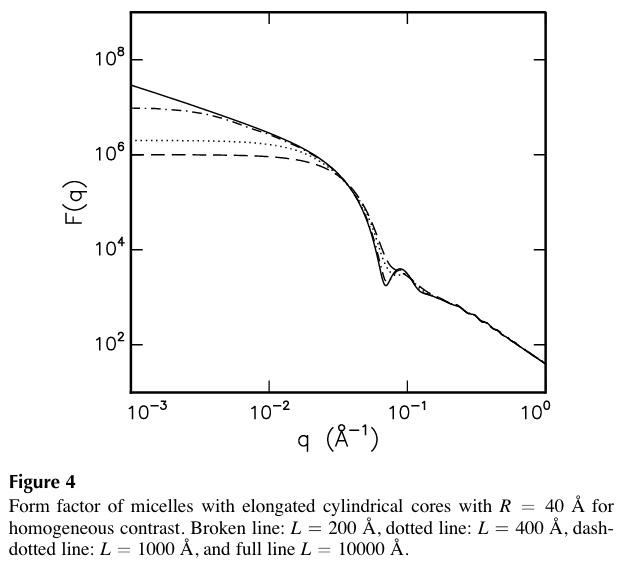

Length : 200 Å 
Length : 400 Å 
Length : 1000 Å 
Length : 10000 Å 


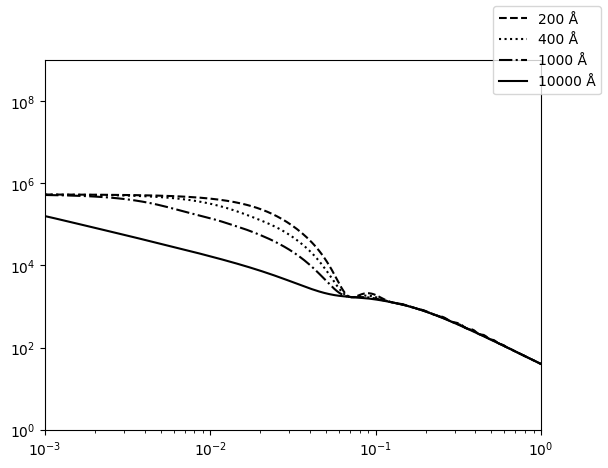

CPU times: user 441 ms, sys: 78.2 ms, total: 519 ms
Wall time: 213 ms


In [13]:
%%time
fig, ax = plt.subplots()
linestyles = ['dashed','dotted','dashdot', 'solid']
for i in range(4):
    print('Length : %d Å '%L[i])
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': L[i],
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-3), np.log10(1), 200)
    Iq_micelle = micelle_longcylinder_kernel(q, **params)
    ax.loglog(q, Iq_micelle, label='%d Å'%L[i], ls=linestyles[i], color='k')
    ax.set_ylim([1e0, 1e9])
    ax.set_xlim([1e-3, 1e0])
fig.legend()
plt.show()